In [4]:
import os
from utils import DataSeq, load_ids

import numpy as np
import pandas as pd
import skimage.io as io

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import F1Score
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.losses import Loss

import keras_tuner as kt

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [5]:
path = "./Train_non_experts_simple/"
batch_size = 8
epochs = 10

In [6]:
ids, labels = load_ids(path)
print(ids.shape, labels.shape)
X_train, X_valid, y_train, y_valid = train_test_split(ids, labels, test_size=0.2, random_state=42)
print(y_train.shape, y_valid.shape)

(75243,) (75243, 3)
(60194, 3) (15049, 3)


In [7]:
# Loading images with generator

train_seq = DataSeq(X_train, y_train)
valid_seq = DataSeq(X_valid, y_valid)

train_steps = len(X_train) // batch_size
valid_steps = len(X_valid) // batch_size

# Focal loss

In [8]:
# This function receives onehot encoded labels
def calculate_weigths(y):
    y = np.argmax(y, axis=-1)
    counts = np.unique(y, return_counts=True)[1]
    weights = 1 / (counts / len(y))
    sum_weights = np.sum(weights)
    return weights / sum_weights

def calculate_weigths2(y):
    y = np.argmax(y, axis=-1)
    counts = np.unique(y, return_counts=True)[1]
    return 1 - (counts / len(y))

def calculate_weigths3(y):
    y = np.argmax(y, axis=-1)
    counts = np.unique(y, return_counts=True)[1]
    return 1 / counts


class FocalLoss(Loss):
    def __init__(self, gamma=2.0, alpha=None, num_classes=None):
        super().__init__()
        self.gamma = gamma
        if num_classes is None:
            raise ValueError("The 'num_classes' parameter must be specified.")
        if alpha is None:
            alpha = [1 for _ in range(num_classes)]
        elif len(alpha) != num_classes:
            raise ValueError("The length of 'alpha' must be equal to 'num_classes'.")
        self.alpha = tf.convert_to_tensor(alpha, dtype=tf.float32)

    def call(self, y_true, y_pred):
        y_pred_clip = tf.clip_by_value(y_pred, clip_value_min=1e-4, clip_value_max=1-1e-4)
        cce = tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
        entropy = cce(y_true, y_pred)

        weight = tf.math.pow(1.0 - y_pred_clip, self.gamma) 
        focal = tf.reduce_sum(y_true * self.alpha * weight, axis=1)
        loss = focal * entropy
        
        return tf.reduce_mean(loss)


def focal_loss(y_true, y_pred):
    y_pred = tf.clip_by_value(y_pred, clip_value_min= 1e-9, clip_value_max=1-1e-9)

    indices = tf.math.argmax(y_true, axis=1)
    print(indices)

    entropy = -tf.gather(tf.math.log(y_pred), indices=indices, batch_dims=1, axis=1)
    return tf.reduce_sum(entropy, axis=-1)

print(calculate_weigths3(labels))
print(calculate_weigths2(labels))
print(calculate_weigths(labels))

[2.68384326e-05 3.61428365e-05 9.69461949e-05]
[0.50480443 0.63228473 0.86291084]
[0.16781628 0.22599518 0.60618853]


# Hyperparameter Tuning

In [9]:
def build_model(hp = None):
    input_layer = Input(shape=(224, 224, 3))

    data_augmentation = tf.keras.Sequential([
        input_layer,
        tf.keras.layers.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.RandomRotation(0.15),
    ])
    
    vgg = tf.keras.applications.VGG16(weights=None, include_top=False, input_tensor=data_augmentation.output)
    vgg.load_weights('./vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')
    vgg.trainable = False

    model = vgg.output
    model = Flatten()(model)
    model = Dense(4096, activation='relu')(model)
    model = Dropout(0.25)(model)

    model = Dense(3, activation='softmax')(model)
    
    gama = 2
    alpha = None

    if not hp is None:
        gamma = hp.Float("gamma", min_value=1.0, max_value=5.0, step=0.5)
        alpha1 = hp.Float("alpha1", min_value=0.01, max_value=1, step=0.01)
        alpha2 = hp.Float("alpha2", min_value=0.01, max_value=1, step=0.01)
        alpha3 = hp.Float("alpha3", min_value=0.01, max_value=1, step=0.01)
        alpha = [alpha1, alpha2, alpha3]

    model = Model(input_layer, model, name="Transfer_VGG16")
    
    model.compile(optimizer="adam", loss=FocalLoss(gamma=gamma, alpha=alpha, num_classes=3), metrics=["accuracy"])
    return model

In [10]:
obj = kt.Objective("val_loss", "min")

tuner = kt.BayesianOptimization(
    hypermodel=build_model,
    objective=obj,
    max_trials=10,
    executions_per_trial=1,
    overwrite=False,
    directory='./tuner_results/',
    project_name='Bayesian_Focal_loss',
)

tuner.search_space_summary()

INFO:tensorflow:Reloading Tuner from ./tuner_results/Bayesian_Focal_loss/tuner0.json
Search space summary
Default search space size: 4
gamma (Float)
{'default': 1.0, 'conditions': [], 'min_value': 1.0, 'max_value': 5.0, 'step': 0.5, 'sampling': 'linear'}
alpha1 (Float)
{'default': 0.01, 'conditions': [], 'min_value': 0.01, 'max_value': 1.0, 'step': 0.01, 'sampling': 'linear'}
alpha2 (Float)
{'default': 0.01, 'conditions': [], 'min_value': 0.01, 'max_value': 1.0, 'step': 0.01, 'sampling': 'linear'}
alpha3 (Float)
{'default': 0.01, 'conditions': [], 'min_value': 0.01, 'max_value': 1.0, 'step': 0.01, 'sampling': 'linear'}


In [11]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

# This call is for images using a generator/sequence
tuner.search(train_seq, validation_data=valid_seq, steps_per_epoch=train_steps,
    validation_steps=valid_steps, epochs=epochs, callbacks=[stop_early])


Trial 10 Complete [01h 05m 31s]
val_loss: 0.004637958016246557

Best val_loss So Far: 0.004637958016246557
Total elapsed time: 04h 00m 00s
INFO:tensorflow:Oracle triggered exit


In [12]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
alpha = [best_hps.get('alpha1'), best_hps.get('alpha2'), best_hps.get('alpha3')]

print(f"Optimal value for gamma: {best_hps.get('gamma')}")
print(f"Optimal values of alpha: {alpha}")

Optimal value for gamma: 5.0
Optimal values of alpha: [0.03, 0.05, 0.87]


In [13]:
model = tuner.hypermodel.build(best_hps)
model.summary()

Model: "Transfer_VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_1 (RandomR  (None, 224, 224, 3)       0         
 otation)                                                        
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                    

In [14]:
tuner.results_summary()

Results summary
Results in ./tuner_results/Bayesian_Focal_loss
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 09 summary
Hyperparameters:
gamma: 5.0
alpha1: 0.03
alpha2: 0.05
alpha3: 0.87
Score: 0.004637958016246557

Trial 05 summary
Hyperparameters:
gamma: 3.0
alpha1: 0.04
alpha2: 0.04
alpha3: 0.24000000000000002
Score: 0.005898834206163883

Trial 08 summary
Hyperparameters:
gamma: 4.0
alpha1: 0.17
alpha2: 0.12
alpha3: 0.08
Score: 0.006542039569467306

Trial 07 summary
Hyperparameters:
gamma: 5.0
alpha1: 0.9500000000000001
alpha2: 0.63
alpha3: 0.54
Score: 0.026154233142733574

Trial 06 summary
Hyperparameters:
gamma: 4.5
alpha1: 0.44
alpha2: 0.45
alpha3: 0.99
Score: 0.02766265720129013

Trial 03 summary
Hyperparameters:
gamma: 2.5
alpha1: 0.12
alpha2: 0.48000000000000004
alpha3: 0.97
Score: 0.03921087831258774

Trial 00 summary
Hyperparameters:
gamma: 1.5
alpha1: 0.05
alpha2: 0.59
alpha3: 0.5700000000000001
Score: 0.04604797810316086

Trial 01 summary
Hyperp

In [15]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

history = model.fit(train_seq, validation_data=valid_seq, steps_per_epoch=train_steps,
 validation_steps=valid_steps, epochs=10, callbacks=[stop_early])

Epoch 1/10
7524/7524 [==============================] - 439s 58ms/step - loss: 0.0778 - accuracy: 0.6134 - val_loss: 0.0056 - val_accuracy: 0.6239
Epoch 2/10
7524/7524 [==============================] - 433s 58ms/step - loss: 0.0080 - accuracy: 0.4858 - val_loss: 0.0055 - val_accuracy: 0.6114
Epoch 3/10
7524/7524 [==============================] - 434s 58ms/step - loss: 0.0066 - accuracy: 0.6311 - val_loss: 0.0056 - val_accuracy: 0.5666
Epoch 4/10
7524/7524 [==============================] - 435s 58ms/step - loss: 0.0063 - accuracy: 0.6366 - val_loss: 0.0049 - val_accuracy: 0.6775
Epoch 5/10
7524/7524 [==============================] - 436s 58ms/step - loss: 0.0070 - accuracy: 0.5880 - val_loss: 0.0072 - val_accuracy: 0.3182
Epoch 6/10
7524/7524 [==============================] - 437s 58ms/step - loss: 0.0063 - accuracy: 0.6314 - val_loss: 0.0064 - val_accuracy: 0.7348
Epoch 7/10
7524/7524 [==============================] - 440s 58ms/step - loss: 0.0068 - accuracy: 0.6134 - val_loss: 0

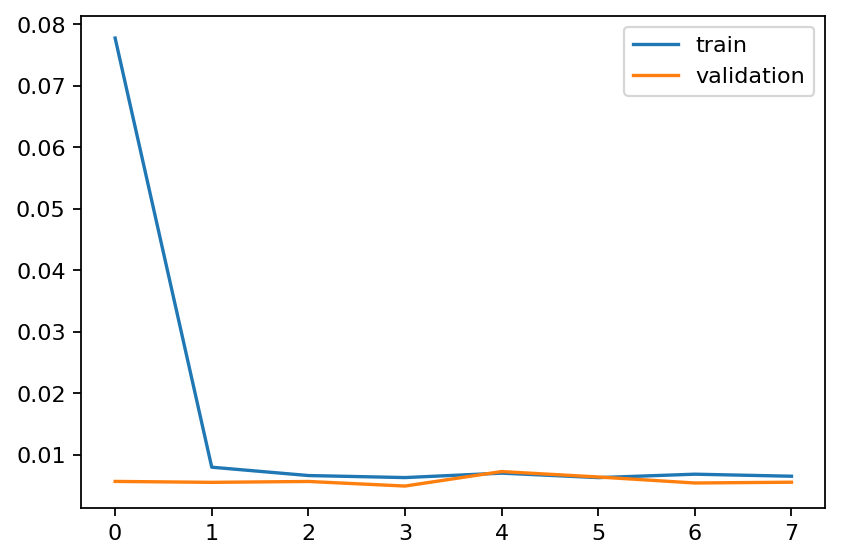

In [16]:
plt.figure(figsize=(6, 4), dpi=160)
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="validation")
plt.legend()
plt.show()

In [17]:
test_path = "./Test/"
test_ids, test_labels = load_ids(test_path)
test_seq = DataSeq(test_ids, test_labels)

In [19]:
y_pred = model.predict(test_seq)
y_pred = np.argmax(y_pred,axis=1)
print(classification_report(np.argmax(test_labels, axis=1), y_pred))


546/546 [==============================] - 18s 32ms/step
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      2692
           1       0.78      0.24      0.37      1196
           2       0.33      0.96      0.49       476

    accuracy                           0.68      4364
   macro avg       0.65      0.67      0.57      4364
weighted avg       0.77      0.68      0.67      4364



In [ ]:
 model.save_weights('./bcss_aug_weights_focal_loss.h5')